In [1]:
import os
import sys
from collections import defaultdict
import itertools

import numpy as np
np.set_printoptions(edgeitems=10)
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import dgl
import dgl.function as fn

PackageDir = '/home/ubuntu/KGReasoning/tKGR'
sys.path.insert(1, PackageDir)

from utils import Data, NeighborFinder

%load_ext autoreload
%autoreload 2

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Using backend: pytorch


### Load Dataset

In [2]:
contents = Data(dataset='ICEWS14_forecasting', add_reverse_relation=False)

In [3]:
id2evts = {k:tuple(v) for k, v in enumerate(contents.train_data)} # zero left for padding

In [4]:
len(contents.train_data)

63685

In [5]:
sub2evt = defaultdict(list)
obj2evt = defaultdict(list)

for i, evt in enumerate(contents.train_data):
    sub2evt[evt[0]].append(i)
    obj2evt[evt[2]].append(i)

In [6]:
sub_sub_edges = []
sub_sub_edges_weight = []
for gr in sub2evt.values():
    for i, j in itertools.combinations(gr, r=2):
        if contents.train_data[j, 3]-contents.train_data[i,3] >= 0:
            sub_sub_edges.append((i, j))
            sub_sub_edges_weight.append(contents.train_data[j,3]-contents.train_data[i,3])
            
obj_obj_edges = []
obj_obj_edges_weight = []
for gr in obj2evt.values():
    for i, j in itertools.combinations(gr, r=2):
        if contents.train_data[j, 3] - contents.train_data[i, 3] >= 0:
            obj_obj_edges.append((i,j))
            obj_obj_edges_weight.append(contents.train_data[j, 3] - contents.train_data[i, 3])
            
sub_obj_edges = []
sub_obj_edges_weight = []
for sub, sub_evt in sub2evt.items():
    for i, j in itertools.product(sub_evt, obj2evt[sub]):
        if contents.train_data[j,3] > contents.train_data[i,3]: # this relation doesn't exist when two events happen simultaneously
            sub_obj_edges.append((i, j))
            sub_obj_edges_weight.append(contents.train_data[j,3]-contents.train_data[i,3])
            
obj_sub_edges = []
obj_sub_edges_weight = []
for obj, obj_evt in obj2evt.items():
    for i, j in itertools.product(obj_evt, sub2evt[obj]):
        if contents.train_data[j,3] > contents.train_data[i,3]: # this relation doesn't exist when two events happen simultaneously
            obj_sub_edges.append((i, j))
            obj_sub_edges_weight.append(contents.train_data[j,3]-contents.train_data[i,3])

### run one of following two blocks
create DGLGraph

In [7]:
# edge point from event happen earlier to later
G = dgl.DGLGraph()
G.add_nodes(len(contents.train_data)+1)
edges = sub_sub_edges + obj_obj_edges + sub_obj_edges + obj_sub_edges
temp = np.array(edges)
u,v = temp[:, 0], temp[:, 1]
G.add_edges(u,v)
G.edata['weight'] = torch.tensor(sub_sub_edges_weight+obj_obj_edges_weight+sub_obj_edges_weight+obj_sub_edges_weight)
G.readonly()

save graph

In [8]:
from dgl.data.utils import save_graphs
graph_labels = {"glabel": torch.tensor([0])}
save_graphs("./data.bin", [G], graph_labels)

create DGLHeteroGraph (doesn't work yet)

In [9]:
# G = dgl.heterograph({
#     ('event', 'sub2sub', 'event'): sub_sub_edges,
#     ('event', 'obj2obj', 'event'): obj_obj_edges,
#     ('event', 'sub2obj', 'event'): sub_obj_edges,
#     ('event', 'obj2sub', 'event'): obj_sub_edges
# })

# G.edges['sub2sub'].data['weight'] = torch.tensor(sub_sub_edges_weight)
# G.edges['obj2obj'].data['weight'] = torch.tensor(obj_obj_edges_weight)
# G.edges['sub2obj'].data['weight'] = torch.tensor(sub_obj_edges_weight)
# G.edges['obj2sub'].data['weight'] = torch.tensor(obj_sub_edges_weight)


In [10]:
del sub_sub_edges
del sub_sub_edges_weight
del obj_obj_edges
del obj_obj_edges_weight
del obj_sub_edges
del obj_sub_edges_weight
del sub_obj_edges
del sub_obj_edges_weight

Load one batch

In [11]:
# filter out event with subject appearing for the first time
train_set = contents.train_data
sub_exists = [False]*len(contents.id2entity)
train_fil = []

for i, evt in enumerate(train_set):
    if not sub_exists[evt[0]]:
        sub_exists[evt[0]] = True
    else:
        train_fil.append(i)
        
print("number of training events: ", len(train_fil))

number of training events:  58667


In [12]:
for batch_idx, sample in enumerate(DataLoader(train_fil, batch_size=8, shuffle=True)):
    print(sample)
    break

tensor([31747,  8802, 24329, 49701, 14830, 60879, 40711,  6194])


initialize start subgraph

In [13]:
SG_queries = []
for evt in sample.numpy():
    cand = np.array(sub2evt[id2evts[evt][0]])
    cand_fil = cand[cand<evt]
    ngh = cand_fil[-20:]
    SG_queries.append(torch.tensor(ngh))

In [14]:
SG_queries

[tensor([26423, 26424, 26681, 27243, 27244, 27245, 27804, 27805, 28031, 28032,
         28033, 28321, 28322, 28323, 29402, 29701, 30000, 30573, 31479, 31746]),
 tensor([2726, 5635]),
 tensor([22329, 23498]),
 tensor([38660, 38661, 39208, 39209, 39210, 40458, 43083, 43084, 45098, 45099,
         45327, 45462, 45681, 45682, 46005, 46573, 46574, 48620, 49201, 49448]),
 tensor([13876, 14062, 14063, 14219, 14220, 14221, 14222, 14223, 14224, 14225,
         14527, 14528, 14529, 14530, 14531, 14532, 14533, 14534, 14535, 14536]),
 tensor([  106,  3111,  5826,  6344,  9538, 13657, 17817, 22985, 25747, 31449,
         31991, 35729, 43854, 44151, 45932, 48818, 50490, 52548, 56316]),
 tensor([27217, 27998, 27999, 28804, 29957, 30529, 30942, 30943, 31436, 31437,
         31983, 34503, 35394, 37479, 38294, 40026, 40384, 40385, 40386, 40710]),
 tensor([3243])]

In [15]:
G.find_edges(G.subgraph(SG_queries[0]).parent_eid)

(tensor([26423, 26423, 26423, 26423, 26423, 26423, 26423, 26423, 26423, 26423,
         26423, 26423, 26423, 26423, 26423, 26423, 26423, 26423, 26423, 26424,
         26424, 26424, 26424, 26424, 26424, 26424, 26424, 26424, 26424, 26424,
         26424, 26424, 26424, 26424, 26424, 26424, 26424, 26424, 26424, 26424,
         26424, 26424, 26424, 26424, 26424, 26681, 26681, 26681, 26681, 26681,
         26681, 26681, 26681, 26681, 26681, 26681, 26681, 26681, 26681, 26681,
         26681, 26681, 26681, 26681, 26681, 26681, 26681, 26681, 26681, 27243,
         27243, 27243, 27243, 27243, 27243, 27243, 27243, 27243, 27243, 27243,
         27243, 27243, 27243, 27243, 27243, 27243, 27243, 27243, 27243, 27243,
         27243, 27244, 27244, 27244, 27244, 27244, 27244, 27244, 27244, 27244,
         27244, 27244, 27244, 27244, 27244, 27244, 27244, 27244, 27244, 27244,
         27245, 27245, 27245, 27245, 27245, 27245, 27245, 27245, 27245, 27245,
         27245, 27245, 27245, 27245, 27245, 27804, 2

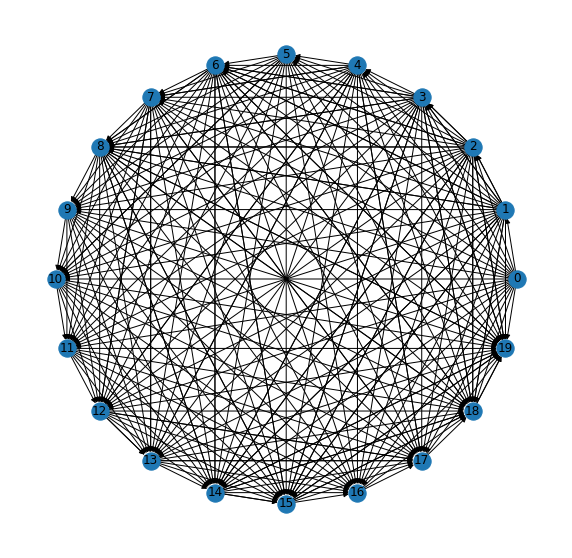

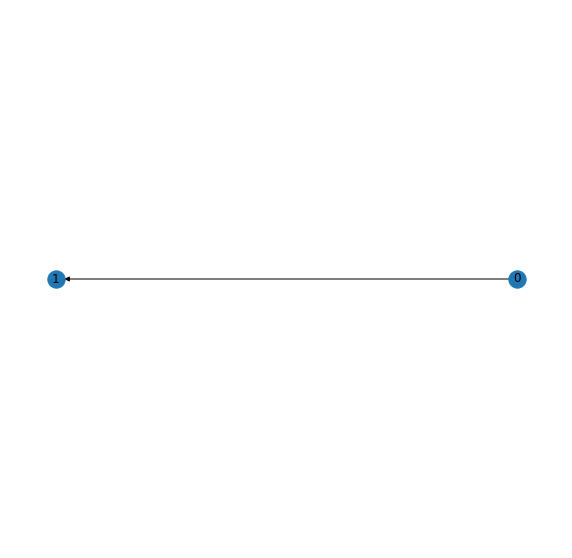

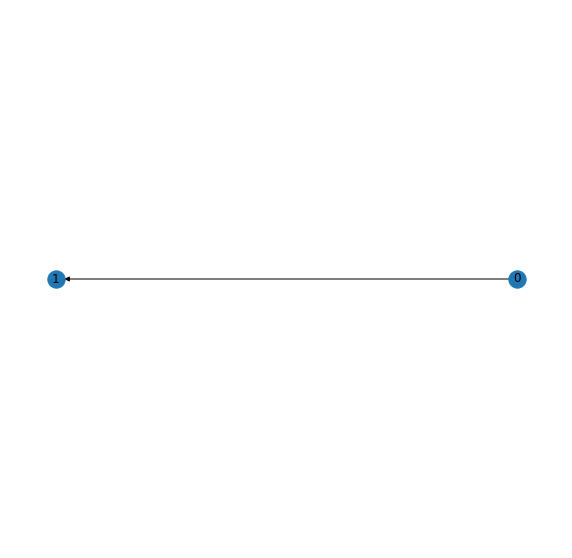

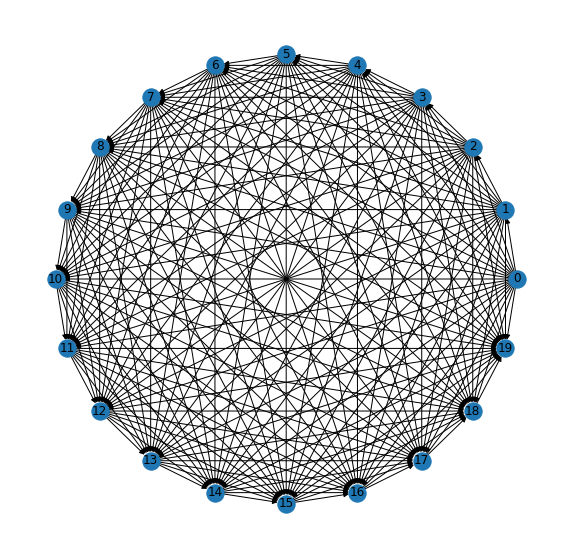

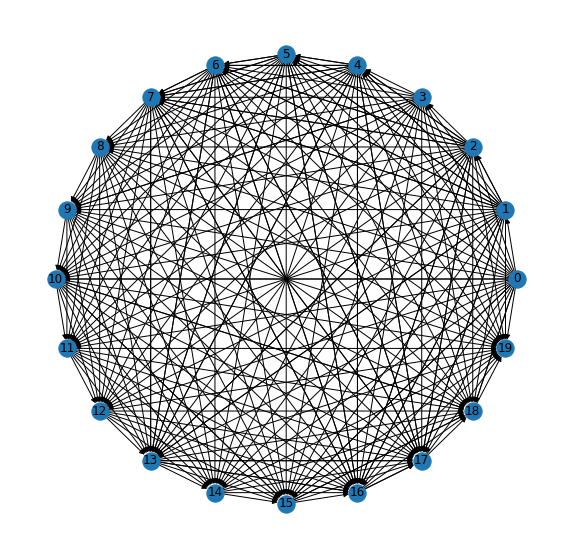

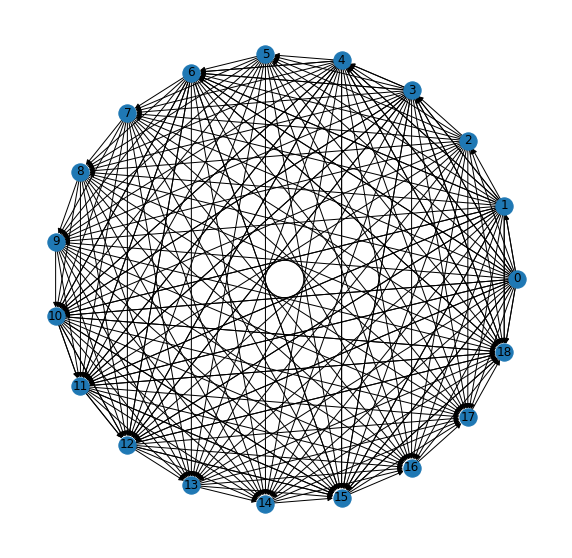

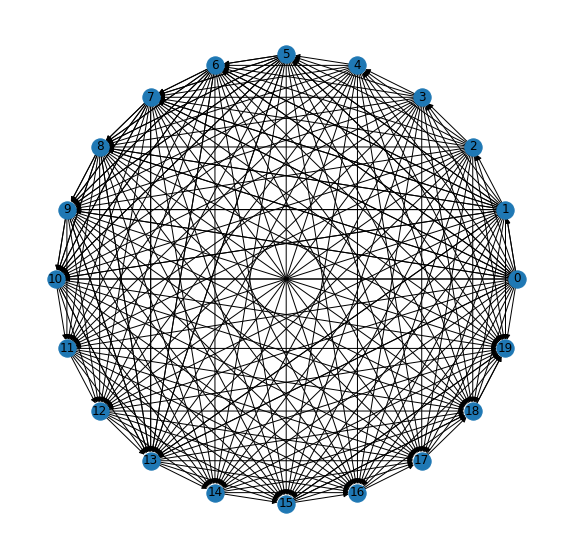

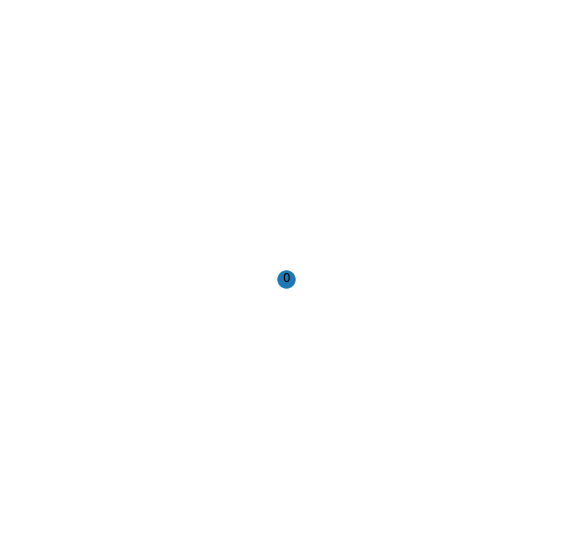

In [16]:
for sg in G.subgraphs(SG_queries):
    fig, ax = plt.subplots(figsize=(10,10))
    sg_nx = sg.to_networkx()
    pos = nx.kamada_kawai_layout(sg_nx)
    nx.draw(sg_nx, with_labels=True, ax=ax, pos=pos)

## Model

In [95]:
import pdb

class MultiHeadGATLayer(nn.Module):
    """
    Multi-Head Attention
    """
    def __init__(self, dim_model, n_head):
        "h: number of heads; dim_model: hidden dimension"
        super(MultiHeadGATLayer, self).__init__()
        self.d_k = 7 * dim_model // n_head # 7*dim_model (sub, rel, obj, time, q_sub, q_rel, q_ts)
        self.d_v = 4 * dim_model // n_head # 4*dim_model (sub, rel, obj, time)
        self.n_head = n_head
        # W_q, W_k, W_v, W_o
        self.attention_func_wq = nn.Linear(7*dim_model, 7*dim_model, bias=False)
        self.attention_func_wk = nn.Linear(7*dim_model, 7*dim_model, bias=False)
        self.attention_func_wv = nn.Linear(4*dim_model, 4*dim_model, bias=False)
        self.attention_func_wo = nn.Linear(4*dim_model, 4*dim_model, bias=False)

    def get(self, x, context, fields='qkv'):
        "Return a dict of queries / keys / values."
        batch_size = x.shape[0]
        ret = {}
        x_cont = torch.cat([x, context], dim=1)
        if 'q' in fields:
            ret['q'] = self.attention_func_wq(x_cont).view(batch_size, self.n_head, self.d_k)
        if 'k' in fields:
            ret['k'] = self.attention_func_wk(x_cont).view(batch_size, self.n_head, self.d_k)
        if 'v' in fields:
            ret['v'] = self.attention_func_wv(x).view(batch_size, self.n_head, self.d_v)
        return ret
    
    def get_o(self, x):
        "get output of the multi-head attention"
        batch_size = x.shape[0]
        return self.attention_func_wo(x.view(batch_size, -1))


import copy
def clones(module, k):
    return nn.ModuleList(
        copy.deepcopy(module) for _ in range(k)
    )

class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = clones(layer, N)
        self.norm = torch.nn.LayerNorm(4*layer.size)
        
    def pre_func(self, i, fields='qkv'):
        layer = self.layers[i]
        def func(nodes):
            x = nodes.data['event_embed']
            context = nodes.data['query_embed']
            norm_x = layer.sublayer[0].norm(x)
            norm_context = layer.sublayer[1].norm(context)
            return layer.self_attn.get(norm_x, norm_context, fields=fields)
        return func
    
    def post_func(self, i):
        """
        1, Normalize (softmax denominator) and get output of multi-Head attention
        2, Applying a two layer position-wise feed forward layer on x then add residual connection:
        """
        layer = self.layers[i]
        def func(nodes):
            x, wv, z = nodes.data['event_embed'], nodes.data['wv'], nodes.data['z']
            o = layer.self_attn.get_o(wv / z)
            x = x + layer.sublayer[0].dropout(o)
            x = layer.sublayer[0](x, layer.feed_forward)
            return {'event_embed': x if i < self.N - 1 else self.norm(x)}
        return func
    
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn # (key, query, value, mask)
        self.feed_forward = feed_forward
        self.sublayer = [SubLayerWrapper(4*size, dropout), SubLayerWrapper(3*size, dropout)]
        
class SubLayerWrapper(nn.Module):
    '''
    The module wraps normalization, dropout, residual connection into one equation:
    sublayerwrapper(sublayer)(x) = x + dropout(sublayer(norm(x)))
    '''
    def __init__(self, size, dropout):
        super(SubLayerWrapper, self).__init__()
        self.norm = torch.nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))
        
def src_dot_dst(src_field, dst_field, out_field):
    def func(edges):
        return {out_field: (edges.src[src_field] * edges.dst[dst_field]).sum(-1, keepdim=True)}

    return func

def scaled_exp(field, scale_constant):
    def func(edges):
        # clamp for softmax numerical stability
        return {field: torch.exp((edges.data[field] / scale_constant).clamp(-5, 5))}

    return func

class GAT(nn.Module):
    def __init__(self, G, encoder, dim_model, h, event_encoder, id2evts):
        super(GAT, self).__init__()
        self.G = G
        self.encoder = encoder
        self.h = h
        self.d_k = 7 * dim_model // h
        self.event_encoder = event_encoder # init event embedding by concatenating embeddings of entities, relation and timestamp
        self.id2evts = id2evts
        
    def propagate_attention(self, g, eids):
        # Compute attention score
        g.apply_edges(src_dot_dst('k', 'q', 'score'), eids)
        g.apply_edges(scaled_exp('score', np.sqrt(self.d_k)), eids)
        # Update node state
        g.send_and_recv(eids,
                        [fn.src_mul_edge('v', 'score', 'v'),
                         fn.src_mul_edge('flow_score', 'score', 'flow_score'),
                         fn.copy_e('score', 'score')], # to message
                        [fn.sum('v', 'wv'), fn.sum('score', 'z'), fn.sum('flow_score', 'flow_score')])

    def update_graph(self, g, eids, pre_pairs, post_pairs):
        # pre-compute queries and key_value pairs
        for pre_func, nids in pre_pairs:
            g.apply_nodes(pre_func, nids)
        self.propagate_attention(g, eids)
        # post-compute
        for post_func, nids in post_pairs:
            g.apply_nodes(post_func, nids)
            
    def initialize(self, queries, SG_queries):
        """
        queries: 1d tensor (batch_size,)
        SG_queries: list of tensor, each tensor is the index of neighbor events for queries
        """
        
        # query embedding
        sample_evts = np.array([[*self.id2evts[evt_idx][:-1]]for evt_idx in queries.numpy()])
        sample_sub = sample_evts[:, 0]
        sample_rel = sample_evts[:, 1]
        sample_ts = sample_evts[:, 3]

        sample_obj = sample_evts[:, 2]

        sample_sub_embed_th = self.event_encoder.ent_raw_embed(torch.from_numpy(sample_sub).to(torch.int64))
        sample_rel_embed_th = self.event_encoder.rel_raw_embed(torch.from_numpy(sample_rel).to(torch.int64))
        sample_ts_embed_th = self.event_encoder.ts_raw_embed(torch.from_numpy(sample_ts[:, np.newaxis]).to(torch.int64)).squeeze(1)
        sample_embed_cat = torch.cat([sample_sub_embed_th, sample_rel_embed_th, sample_ts_embed_th], axis=1)
        
        SG_list = self.G.subgraphs(SG_queries)
        self.sample_query_embed = sample_embed_cat
        
        for i, sg in enumerate(SG_list):
            # query embedding
            context = self.sample_query_embed[i].expand(sg.number_of_nodes(), -1) # expand create a new view rather than allocating new memory
            sg.ndata['query_embed'] = context

            # event embedding
            sg_evts = np.array([[*self.id2evts[evt_idx][:-1]] for evt_idx in sg.parent_nid.numpy()])
            sg_event_embed = self.event_encoder(sg_evts)
            sg.ndata['event_embed'] = sg_event_embed

            # init score
            sg.ndata['flow_score'] = torch.ones(sg.number_of_nodes(),1,1, requires_grad=True)
            
        bg = dgl.batch(SG_list)
    
        pre_func = self.encoder.pre_func(0, 'qkv')
        post_func = self.encoder.post_func(0)
        self.update_graph(bg, bg.edges(), [(pre_func, bg.edges()[0])], [(post_func, bg.edges()[1])])
        
        return bg
        
    
    def forward(self, bg):
        """
        g: DGLGraph, preprocessed: node raw embedding from entity, relation and time embedding
        nodes: 2-d numpy array: (node_idx, sub_idx, rel_idx, obj_idx, timestamp)
        """
        for i in range(1, self.encoder.N):
            # dynamically expand graph
            SG_list = dgl.unbatch(bg)
            new_SG_nodes = []
            for i, sg in enumerate(dgl.unbatch(bg)):
                neighbor = torch.cat([sub.layer_parent_nid(0)[-10:] 
                                      for sub in dgl.contrib.sampling.sampler.NeighborSampler(
                                          G, 1, expand_factor=10000, num_hops=1, seed_nodes = sg.ndata['_ID'])])
                sub_nodes = torch.unique(torch.cat([neighbor, sg.ndata['_ID']]))
                new_sg = G.subgraph(sub_nodes)
                new_sg.ndata['query_embed'] = self.sample_query_embed[i].expand(new_sg.number_of_nodes(), -1)
                new_sg_evts = np.array([[*self.id2evts[evt_idx][:-1]] for evt_idx in new_sg.ndata['_ID'].numpy()])
                new_sg.ndata['event_embed'] = self.event_encoder(new_sg_evts)
                old_sg_nodes_in_new_sg = new_sg.map_to_subgraph_nid(sg.ndata['_ID'])
                new_sg.nodes[old_sg_nodes_in_new_sg].data['flow_score'] = sg.ndata['flow_score']
                new_sg.nodes[old_sg_nodes_in_new_sg].data['degree_inv'] = sg.o_
                new_sg.send_and_recv(new_sg.edges(), [fn.copy])
                new_sg.ndata['flow_score']
                new_sub.nodes[new_sg.map_to_subgraph_nid(sg.ndata['_ID'])].data['test'] = torch.randn(20,10)
                
            
                
            
            pre_func = self.encoder.pre_func(i, 'qkv')
            post_func = self.encoder.post_func(i)
            edges = g.edges()
            nodes = g.nodes()
            self.update_graph(g, edges, [(pre_func, nodes)], [(post_func, nodes)])
            
            # pruning
            # TBD
            
            # update entity graph
            
        return g.ndata.pop('x')
    
class TimeEncode(torch.nn.Module):
    '''
    This class implemented the Bochner's time embedding
    '''

    def __init__(self, dim_model, device='cpu'):
        '''

        :param expand_dim: number of samples draw from p(w), which are used to estimate kernel based on MCMC
        refer to Self-attention with Functional Time Representation Learning for more detail
        '''
        super(TimeEncode, self).__init__()

        time_dim = dim_model
        self.basis_freq = torch.nn.Parameter(torch.from_numpy(1 / 10 ** np.linspace(0, 9, time_dim)).float())
        self.phase = torch.nn.Parameter(torch.zeros(time_dim).float())


    def forward(self, ts):
        '''

        :param ts: [batch_size, seq_len]
        :return: [batch_size, seq_len, time_dim]
        '''
        batch_size = ts.size(0)
        seq_len = ts.size(1)

        ts = torch.unsqueeze(ts, dim=2)
        # print("Forward in TimeEncode: ts is on ", ts.get_device())
        map_ts = ts * self.basis_freq.view(1, 1, -1)  # [batch_size, seq_len, time_dim]
        map_ts += self.phase.view(1, 1, -1)

        harmonic = torch.cos(map_ts)
        return harmonic
    
class EventEncode(torch.nn.Module):
    def __init__(self, dim_model, id2entity, id2relation):
        super(EventEncode, self).__init__()
        self.id2entity = id2entity
        self.id2relation = id2relation
        self.ent_raw_embed = torch.nn.Embedding(len(id2entity), dim_model)
        self.rel_raw_embed = torch.nn.Embedding(len(id2relation), dim_model)
        self.ts_raw_embed = TimeEncode(dim_model)
        
    def forward(self, sg_evts):
        """
        events_idx: 1d tensor of events
        """
        sg_sub = sg_evts[:, 0]
        sg_rel = sg_evts[:, 1]
        sg_obj = sg_evts[:, 2]
        sg_ts = sg_evts[:, 3]
        sg_sub_embed_th = self.ent_raw_embed(torch.from_numpy(sg_sub).to(torch.int64))
        sg_rel_embed_th = self.rel_raw_embed(torch.from_numpy(sg_rel).to(torch.int64))
        sg_obj_embed_th = self.ent_raw_embed(torch.from_numpy(sg_obj).to(torch.int64))
        sg_ts_embed_th = self.ts_raw_embed(torch.from_numpy(sg_ts[:, np.newaxis]).to(torch.int64)).squeeze(1)
        sg_embed_cat = torch.cat([sg_sub_embed_th, sg_rel_embed_th, sg_obj_embed_th, sg_ts_embed_th], axis=1)
        return sg_embed_cat

hyperparameter

In [96]:
dim_model = 128 # dimension of entity, relation and time
dropout = 0.1
DP_step = 2
head = 1
batch_size = 8
num_neighbors = 20

parameters

In [97]:
# note that there is difference between current model and TGAN: no offset for entity and relation identity in embedding
num_entity = len(contents.id2entity)
num_relation = len(contents.id2relation)

models

In [98]:
attn = MultiHeadGATLayer(dim_model, head)
ff = torch.nn.Linear(4*dim_model, 4*dim_model) # feed forward after multihead concatenatation
encoder = Encoder(EncoderLayer(dim_model, copy.deepcopy(attn), copy.deepcopy(ff), 0.1), DP_step) # event node embedding
event_encoder = EventEncode(dim_model, contents.id2entity, contents.id2relation)
model = GAT(G, encoder, dim_model, head, event_encoder, id2evts)

ent_raw_embed = torch.nn.Embedding(num_entity, dim_model)
rel_raw_embed = torch.nn.Embedding(num_relation, dim_model)
ts_raw_embed = TimeEncode(dim_model)

### Training

In [112]:
for batch_idx, sample in enumerate(DataLoader(np.arange(len(contents.train_data)), batch_size=batch_size, shuffle=True)):
    
    SG_queries = [sub.layer_parent_nid(0)[-num_neighbors:] 
                  for sub in dgl.contrib.sampling.sampler.NeighborSampler(
                      G, 1, expand_factor=10000, num_hops=1, seed_nodes = sample)]
    
    bg = model.initialize(sample, SG_queries)
    break

In [133]:
SG_queries

[tensor([27867, 29778, 30077, 30360, 31559, 32987, 34052, 35005, 35006, 35851,
         36720, 37598, 38426, 40162, 43961, 43962, 49765, 49766, 49993, 49994]),
 tensor([31209, 31210, 32057, 32696, 32938, 32939, 32940, 33264, 33612, 33978,
         34724, 36932, 37239, 37552, 45338, 54137, 54138, 54376, 54377, 58851]),
 tensor([19087, 30433, 32746, 32747, 33081, 33753, 35300, 48731, 57280, 61035,
         61036]),
 tensor([16189, 30683, 34783, 35275, 35576, 38759, 39900, 42570, 42571, 42572,
         42883, 43436, 48705, 48706, 49270, 56958, 56959, 57250, 57554, 57871]),
 tensor([52298, 52299, 53736, 53737, 55142, 57411, 58499, 58500, 58501, 58502,
         58503, 58794, 58795, 60217, 61831, 61832, 61833, 62244, 62869, 63481]),
 tensor([33538, 33539, 34242, 37492, 38306, 38307, 39458, 40733, 43856, 45435,
         46267, 47394, 49654, 50644, 50880, 51340, 51886, 52031, 55306, 63158]),
 tensor([62517, 62797, 62798, 62799, 62800, 63097, 63098, 63099, 63100, 63101,
         63102, 63103, 6

In [113]:
sg = dgl.unbatch(bg)[0]

In [157]:
sg.nodes

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19])

In [131]:
sg.ndata['_ID']

tensor([27867, 29778, 30077, 30360, 31559, 32987, 34052, 35005, 35006, 35851,
        36720, 37598, 38426, 40162, 43961, 43962, 49765, 49766, 49993, 49994])

In [158]:
sg = dgl.unbatch(bg)[0]
neighbor = torch.cat([sub.layer_parent_nid(0)[-10:] 
 for sub in dgl.contrib.sampling.sampler.NeighborSampler(G, 1, expand_factor=10000, num_hops=1, seed_nodes = sg.ndata['_ID'])])
sub_nodes = torch.unique(torch.cat([neighbor, sg.ndata['_ID']]))

In [148]:
torch.unique(sub_nodes).shape

torch.Size([190])

In [159]:
new_sub = G.subgraph(sub_nodes)

In [168]:
new_sub.nodes[new_sub.map_to_subgraph_nid(sg.ndata['_ID'])].data['test'] = torch.randn(20,10)

In [123]:
for batch_idx, sample in enumerate(DataLoader(np.arange(len(contents.train_data)), batch_size=batch_size, shuffle=True)):
    
    SG_queries = []
    for evt in sample.numpy():
        ngh = sub2evt[id2evts[evt][0]][-num_neighbors:]
        SG_queries.append(torch.tensor(ngh))
        
    # query embedding
    sample_evts = np.array([[*id2evts[evt_idx][:-1]]for evt_idx in sample.numpy()])
    sample_sub = sample_evts[:, 0]
    sample_rel = sample_evts[:, 1]
    sample_ts = sample_evts[:, 3]

    sample_obj = sample_evts[:, 2]
    
    sample_sub_embed_th = ent_raw_embed(torch.from_numpy(sample_sub).to(torch.int64))
    sample_rel_embed_th = rel_raw_embed(torch.from_numpy(sample_rel).to(torch.int64))
    sample_ts_embed_th = ts_raw_embed(torch.from_numpy(sample_ts[:, np.newaxis]).to(torch.int64)).squeeze(1)
    sample_embed_cat = torch.cat([sample_sub_embed_th, sample_rel_embed_th, sample_ts_embed_th], axis=1)
    
    SG_list = G.subgraphs(SG_queries)

    for i, sg in enumerate(SG_list):
        # query embedding
        query_embed = sample_embed_cat[i].expand(sg.number_of_nodes(), -1) # expand create a new view rather than allocating new memory
        sg.ndata['query_embed'] = query_embed

        # event embedding
        evts_parent_id = sg.parent_nid
        sg_evts = np.array([[*id2evts[evt_idx][:-1]] for evt_idx in evts_parent_id.numpy()])
        sg_sub = sg_evts[:, 0]
        sg_rel = sg_evts[:, 1]
        sg_obj = sg_evts[:, 2]
        sg_ts = sg_evts[:, 3]
        sg_sub_embed_th = ent_raw_embed(torch.from_numpy(sg_sub).to(torch.int64))
        sg_rel_embed_th = rel_raw_embed(torch.from_numpy(sg_rel).to(torch.int64))
        sg_obj_embed_th = ent_raw_embed(torch.from_numpy(sg_obj).to(torch.int64))
        sg_ts_embed_th = ts_raw_embed(torch.from_numpy(sg_ts[:, np.newaxis]).to(torch.int64)).squeeze(1)
        sg_embed_cat = torch.cat([sg_sub_embed_th, sg_rel_embed_th, sg_obj_embed_th, sg_ts_embed_th], axis=1)
        sg.ndata['event_embed'] = sg_embed_cat

        # init score
        sg.ndata['flow_score'] = torch.ones(sg.number_of_nodes(),1,1, requires_grad=True)
      
    break
    bg = dgl.batch(SG_list)

In [124]:
SG_list[0]

DGLGraph(num_nodes=20, num_edges=273,
         ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'query_embed': Scheme(shape=(384,), dtype=torch.float32), 'event_embed': Scheme(shape=(512,), dtype=torch.float32), 'flow_score': Scheme(shape=(1, 1), dtype=torch.float32)}
         edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})

In [125]:
bg = dgl.batch(SG_list)

In [126]:
SG_list = dgl.unbatch(bg)

In [128]:
SG_list[0].parent_nid

DGLError: We only support parent_nid for subgraphs.

query embedding

In [121]:
sample_evts = np.array([[*id2evts[evt_idx][:-1]]for evt_idx in sample.numpy()])
sample_sub = sample_evts[:, 0]
sample_rel = sample_evts[:, 1]
sample_ts = sample_evts[:, 3]

sample_obj = sample_evts[:, 2]

In [122]:
sample_sub_embed_th = ent_raw_embed(torch.from_numpy(sample_sub).to(torch.int64))
sample_rel_embed_th = rel_raw_embed(torch.from_numpy(sample_rel).to(torch.int64))
sample_ts_embed_th = ts_raw_embed(torch.from_numpy(sample_ts[:, np.newaxis]).to(torch.int64)).squeeze(1)
sample_embed_cat = torch.cat([sample_sub_embed_th, sample_rel_embed_th, sample_ts_embed_th], axis=1)

In [145]:
SG_list = G.subgraphs(SG_queries)

for i, sg in enumerate(SG_list):
    # query embedding
    query_embed = sample_embed_cat[i].expand(sg.number_of_nodes(), -1) # expand create a new view rather than allocating new memory
    sg.ndata['query_embed'] = query_embed
    
    # event embedding
    evts_parent_id = sg.parent_nid
    sg_evts = np.array([[*id2evts[evt_idx][:-1]] for evt_idx in evts_parent_id.numpy()])
    sg_sub = sg_evts[:, 0]
    sg_rel = sg_evts[:, 1]
    sg_obj = sg_evts[:, 2]
    sg_ts = sg_evts[:, 3]
    sg_sub_embed_th = ent_raw_embed(torch.from_numpy(sg_sub).to(torch.int64))
    sg_rel_embed_th = rel_raw_embed(torch.from_numpy(sg_rel).to(torch.int64))
    sg_obj_embed_th = ent_raw_embed(torch.from_numpy(sg_obj).to(torch.int64))
    sg_ts_embed_th = ts_raw_embed(torch.from_numpy(sg_ts[:, np.newaxis]).to(torch.int64)).squeeze(1)
    sg_embed_cat = torch.cat([sg_sub_embed_th, sg_rel_embed_th, sg_obj_embed_th, sg_ts_embed_th], axis=1)
    sg.ndata['event_embed'] = sg_embed_cat
    
    # init score
    sg.ndata['flow_score'] = torch.ones(sg.number_of_nodes(),1,1, requires_grad=True)

In [153]:
bg = dgl.batch(SG_list)

In [154]:
pre_func = encoder.pre_func(0, 'qkv')
post_func = encoder.post_func(0)
edges = bg.edges()
nodes = bg.nodes()

In [155]:
for pre_func, nids in [(pre_func, nodes)]:
    bg.apply_nodes(pre_func, nids)

In [156]:
model.propagate_attention(bg, edges)

In [158]:
# post-compute
for post_func, nids in [(post_func, nodes)]:
    bg.apply_nodes(post_func, nids)

In [160]:
bg.edata

{'_ID': tensor([ 8683239, 20086355,  8683240,  ...,  7948180,  7948181, 23293218]), 'score': tensor([[[1.2810]],

        [[1.2810]],

        [[1.1564]],

        ...,

        [[1.1274]],

        [[0.8586]],

        [[0.8586]]], grad_fn=<IndexCopyBackward>)}

In [51]:
hop1neigh = dgl.contrib.sampling.sampler.NeighborSampler(G, 1, expand_factor=10000, num_hops=1, seed_nodes = sample, neighbor_type='obj_sub')

In [52]:
for nv in hop1neigh:
    print(nv.layer_parent_nid(0)[-20:])

DGLError: [20:19:51] /opt/dgl/include/dgl/packed_func_ext.h:117: Check failed: ObjectTypeChecker<TObjectRef>::Check(sptr.get()): Expected type graph.Graph but get graph.HeteroGraph
Stack trace:
  [bt] (0) /home/ubuntu/KGReasoning/venv/lib/python3.6/site-packages/dgl/libdgl.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x22) [0x7f6eabcae0c2]
  [bt] (1) /home/ubuntu/KGReasoning/venv/lib/python3.6/site-packages/dgl/libdgl.so(dgl::GraphRef dgl::runtime::DGLArgValue::AsObjectRef<dgl::GraphRef>() const+0x38c) [0x7f6eabd0bf5c]
  [bt] (2) /home/ubuntu/KGReasoning/venv/lib/python3.6/site-packages/dgl/libdgl.so(+0xd7c740) [0x7f6eac377740]
  [bt] (3) /home/ubuntu/KGReasoning/venv/lib/python3.6/site-packages/dgl/libdgl.so(DGLFuncCall+0x52) [0x7f6eac2b5c22]
  [bt] (4) /home/ubuntu/anaconda3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f6f35afbec0]
  [bt] (5) /home/ubuntu/anaconda3/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7f6f35afb87d]
  [bt] (6) /home/ubuntu/anaconda3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7f6f35d11ede]
  [bt] (7) /home/ubuntu/anaconda3/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x13915) [0x7f6f35d12915]
  [bt] (8) /home/ubuntu/KGReasoning/venv/bin/python(_PyObject_FastCallDict+0x8b) [0x55bf4db2d6db]



In [37]:
contents.train_data.shape

(63685, 5)

In [144]:
torch.ones(5,1)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])